In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_similarity_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

This kernel demonstrates a quick and naive implementation of a U-Net in Pytorch, trained on a GPU. Enjoy!

In [154]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Image Preparation

In [0]:
# Set some parameters# Set s 
im_width = 128
im_height = 128
im_chan = 1
path_train = '/content/gdrive/My Drive/seep_detection/traindata'
path_masks = '/content/gdrive/My Drive/seep_detection/trainmasks'

train_path_images = os.path.abspath(path_train + "/train_images_256/")
train_path_masks = os.path.abspath(path_train + "/train_masks_256/")

 

In [0]:
train_path_images_list = glob(os.path.join(train_path_images, "*.tif"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.tif"))
 

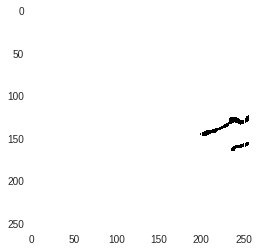

In [157]:
mas = imread('/content/gdrive/My Drive/seep_detection/trainmasks/train_masks_256/041869.000003.tif')
plt.imshow(mas)

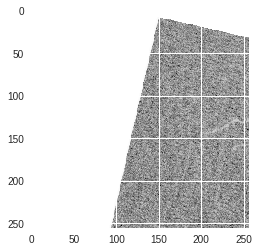

In [158]:
img = imread('/content/gdrive/My Drive/seep_detection/traindata/train_images_256/041869.000003.tif')
plt.imshow(img)

In [0]:
train_ids = next(os.walk(train_path_images))[2]


In [160]:
 

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)


print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/train_images_256/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_masks + '/train_masks_256/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        preserve_range=True)



Getting and resizing train images and masks ... 


In [161]:
"""

# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

"""

'\n\n# Check if training data looks all right\nix = random.randint(0, len(train_ids))\nplt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))\nplt.show()\ntmp = np.squeeze(Y_train[ix]).astype(np.float32)\nplt.imshow(np.dstack((tmp,tmp,tmp)))\nplt.show()\n\n'

# Prepare Images

In [0]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class make_data(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [163]:
X_train.shape

(790, 128, 128, 1)

In [164]:
Y_train.shape

(790, 128, 128, 1)

In [0]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [0]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

We set a random seed for reproducibility.

In [0]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [0]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

You may need to tweak your batch_size based on how much memory you have on your GPU.

In [0]:
make_data_train = make_data(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
make_data_val = make_data(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=make_data_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=make_data_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [170]:
for i in val_loader: # val loader has 5 batches, total 10
  print(len(i))

2
2
2
2
2


# Create U-net model

In [0]:
class double_conv(nn.Module):
  
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
      
        super(double_conv, self).__init__()
        
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16 # channels

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        
        #downsample part
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        ########### deconv /upsample part
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
         
        
        
    def forward(self, inputs):
        # downsample
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # upsample
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

Used BCEWithLogitsLoss since we're comparing pixel by pixel. Did not include a final sigmoid activation as this loss function includes a sigmoid for us.

In [0]:
model = Unet()
model.cuda();

criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [173]:
mean_train_losses = []
mean_val_losses = []
for epoch in range(12):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    trlossmean = torch.mean(torch.stack(train_losses))
    vallossmean = torch.mean(torch.stack(val_losses))
    #print('mean train loss in epoch: ', epoch,' is : ',np.mean(train_losses))
    #print('mean train loss in epoch: ', epoch,' is : ',np.mean(val_losses))
    mean_train_losses.append(trlossmean)
    mean_val_losses.append(vallossmean)
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, trlossmean, vallossmean))

Epoch: 1. Train Loss: 0.4703318476676941. Val Loss: 0.40313345193862915
Epoch: 2. Train Loss: 0.36137980222702026. Val Loss: 0.3232775330543518
Epoch: 3. Train Loss: 0.2873562276363373. Val Loss: 0.2574651539325714
Epoch: 4. Train Loss: 0.22793376445770264. Val Loss: 0.20654122531414032
Epoch: 5. Train Loss: 0.18439684808254242. Val Loss: 0.17166565358638763
Epoch: 6. Train Loss: 0.15418823063373566. Val Loss: 0.14847664535045624
Epoch: 7. Train Loss: 0.13540326058864594. Val Loss: 0.13466182351112366
Epoch: 8. Train Loss: 0.12390484660863876. Val Loss: 0.12655846774578094
Epoch: 9. Train Loss: 0.11663765460252762. Val Loss: 0.12143006175756454
Epoch: 10. Train Loss: 0.10960357636213303. Val Loss: 0.11760833114385605
Epoch: 11. Train Loss: 0.10326237231492996. Val Loss: 0.11719079315662384
Epoch: 12. Train Loss: 0.09916859865188599. Val Loss: 0.11930116266012192


We note that around 11-13 epochs is when we start to worry about overfitting to our training data as we see a rise in our validation loss.

In [0]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)


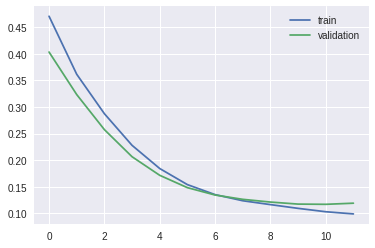

In [175]:
plt.plot(train_loss_series, label='train')
plt.plot(val_loss_series,label = 'validation' )
 
plt.legend()

Finally we compute our IOU score for various thresholds. 

In [0]:
y_pred_true_pairs = []
for images, masks in val_loader:
    images = Variable(images.cuda())
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))

In [0]:
l = y_pred_true_pairs[7][0].reshape(128,128,1)
m = y_pred_true_pairs[7][1].reshape(128,128,1)

In [178]:
l.shape

(128, 128, 1)

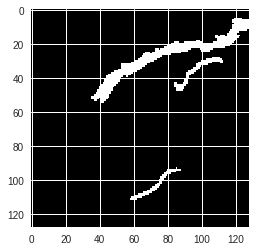

In [179]:
plt.imshow(np.dstack((m,m,m)))
plt.show()

In [180]:
len(y_pred_true_pairs)

79

In [181]:
########not working properly 
for threshold in np.linspace(0, 1, 5):
    
    ious = []
    for y_pred, mask in y_pred_true_pairs:
        #prediction = (y_pred > threshold).astype(int)
        iou = jaccard_similarity_score(mask.flatten(), prediction.flatten()> threshold, normalize=True)
    
        ious.append(iou)
    print(np.mean(ious))
    accuracies = [np.mean(ious > iou_threshold) for iou_threshold in np.linspace(0.5, 0.95, 10)]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))

0.975416738775712
Threshold: 0.0, Metric: 0.981
0.975416738775712
Threshold: 0.2, Metric: 0.981
0.975416738775712
Threshold: 0.5, Metric: 0.981
0.975416738775712
Threshold: 0.8, Metric: 0.981
0.975416738775712
Threshold: 1.0, Metric: 0.981
